In [1]:
##where is the model looking ? -CAM , Grad CAM , Grad CAM ++ 
##which local changes matter the most ? -Occlusion , LIME 
## how much did each feature contribute to the prediction ? -SHAP
##how does output change from baseline to input ? -integrated gradients 

In [2]:
pip install tensorflow-macos==2.15.0

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tensorflow-metal==1.1.0

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets , transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [6]:
pip install captum shap lime scikit-image grad-cam --quiet

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

from captum.attr import IntegratedGradients , Occlusion , GuidedBackprop

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [6]:
from torchvision.models import resnet50, ResNet50_Weights

weights =ResNet50_Weights.DEFAULT
model =resnet50(weights=weights)
model = model.eval().to(device)

##pre processing transform for ImageNet models
preprocess =weights.transforms() 
# Raw PIL Image (800×600) 
#     ↓ Step 1: Resize(232,232)  
# Smaller PIL Image (232×232)  
#     ↓ Step 2: CenterCrop(224,224) 
# Cropped PIL Image (224×224)  
#     ↓ Step 3: ToTensor() 
# Tensor [3,224,224] values 0-1  
#     ↓ Step 4: Normalize(mean/std)  
# Tensor [3,224,224] values -2 to +2  
#     ↓ Step 5: Add batch dim  
# Final: [1,3,224,224] ← READY!

imagenet_labels = weights.meta['categories']

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/sheenachanda/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [03:29<00:00, 489kB/s]


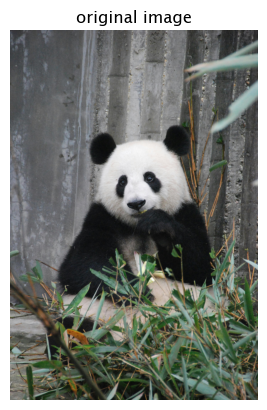

In [17]:
# image_location='pexels-chevanon-1108099.jpg'
image_location='pexels-laurathexplaura-3608263.jpg'

img_pil = Image.open(image_location).convert("RGB")
plt.imshow(img_pil)
plt.axis('off')
plt.title('original image')
plt.show()

In [18]:
def prepare_image(img_pil):
    input_tensor = preprocess(img_pil).unsqueeze(0).to(device)
    return input_tensor ##[c,h,w ] - we want [1,c,h,w]

def predict(input_tensor):
    with torch.no_grad():
        logits = model(input_tensor)
        probs =logits.softmax(dim=1)
    return probs,logits

input_tensor = prepare_image(img_pil)
probs , logits =predict(input_tensor)
top_prob,top_idx =probs.max(dim=1)
pred_label =imagenet_labels[top_idx.item()]

print(f'Top prediction :{pred_label} (prob ={top_prob.item():.3f})')


Top prediction :giant panda (prob =0.456)


### Occlusion Sensitivity

Occlusion is like putting black tape over parts of your image and asking: "Does the model's prediction change when I hide this region?"

If prediction drops → that region is important (high attribution)

If prediction stays same → that region is unimportant (low attribution)

If prediction improves → that region was distracting (negative attribution)

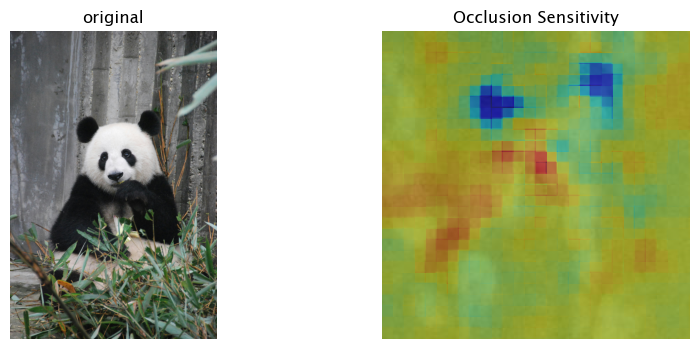

In [19]:
occlusion =Occlusion(model)

#convert image to tensor without gradient
input_tensor.requires_grad =False
# we focus on top pred class

target = top_idx.item()

#occlusion parameters - sliding window 15 *15 , stride =8
attribution_occ = occlusion.attribute(
    input_tensor ,
    strides =(1,8,8) ,
    target =target ,
    sliding_window_shapes =(1,15,15),
    baselines =0
)

#aggregate over channels
attr_occ = attribution_occ.squeeze().detach().cpu().numpy()
attr_occ=attr_occ.sum(axis=0)

#normalize for visualization
attr_occ_norm = (attr_occ -attr_occ.min())/(attr_occ.max()- attr_occ.min() + 1e-8)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img_pil)
plt.title("original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img_pil)
plt.imshow(attr_occ_norm,cmap="jet",alpha=0.5)
plt.title("Occlusion Sensitivity")
plt.axis("off")
plt.show()

### Integrated Gradients (IG)
Integrated Gradients (IG) imagines morphing your image from all-black to full image, computes gradients at 50 snapshots along the way, then averages them to show "which pixels consistently mattered."

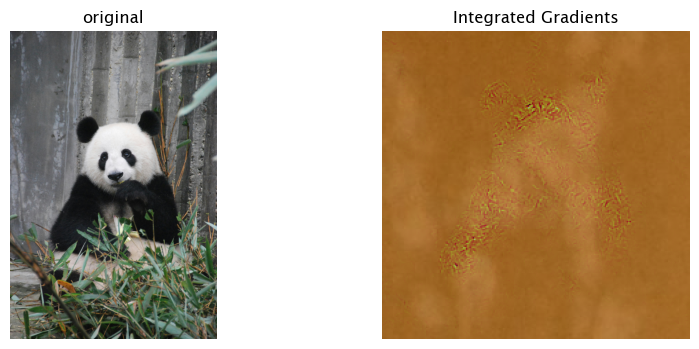

In [20]:
ig = IntegratedGradients(model)

baseline = torch.zeros_like(input_tensor).to(device)

attributions_ig = ig.attribute(
    input_tensor , baselines =baseline ,
    target= target ,
    n_steps =50
)

attr_ig =attributions_ig.squeeze().detach().cpu().numpy()

attr_ig =attr_ig.sum(axis=0)
attr_ig_norm =(attr_ig -attr_ig.min())/(attr_ig.max()- attr_ig.min() + 1e-8)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img_pil)
plt.title("original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img_pil)
plt.imshow(attr_ig,cmap="hot",alpha=0.5)
plt.title("Integrated Gradients")
plt.axis("off")
plt.show()

Understanding requires_grad

In [14]:
import torch

print("=== CASE 1: requires_grad = False (DEFAULT) ===\n")
# Your typical input tensor (like from preprocess())
x = torch.tensor([2.0, 3.0, 4.0])  # Default: requires_grad=False
print(f"x: {x}")
print(f"x.requires_grad: {x.requires_grad}")  # False!
print(f"x.grad: {x.grad}")  # None!

y = x * 3                    # [6.0, 9.0, 12.0]
z = y ** 2                   # [36, 81, 144]
print(f"z: {z}")
print(f"z.requires_grad: {z.requires_grad}")  # False! No graph built

# Try backward() → ERROR!
try:
    z.sum().backward()
except RuntimeError as e:
    print(f"ERROR: {e}")  # "element 0 has no grad_fn"
print()

=== CASE 1: requires_grad = False (DEFAULT) ===

x: tensor([2., 3., 4.])
x.requires_grad: False
x.grad: None
z: tensor([ 36.,  81., 144.])
z.requires_grad: False
ERROR: element 0 of tensors does not require grad and does not have a grad_fn



In [15]:
# === CASE 2: requires_grad = True ===
print("=== CASE 2: requires_grad = True ===\n")
x = torch.tensor([2.0, 3.0, 4.0], requires_grad=True)  # TURN ON TRACKING!
print(f"x: {x}")
print(f"x.requires_grad: {x.requires_grad}")  # True!
print(f"x.grad: {x.grad}")  # None (not computed YET)

y = x * 3                    # PyTorch: "Record this operation!"
z = y ** 2                   # PyTorch: "Record this too!"
print(f"y: {y}")
print(f"z: {z}")
print(f"z.requires_grad: {z.requires_grad}")  # True! Graph built!

# Now backward() WORKS!
out = z.sum()  # 36 + 81 + 144 = 261
out.backward()  # Compute ∂out/∂x for ALL requires_grad=True tensors

print(f"After backward():")
print(f"x.grad: {x.grad}")      # tensor([12., 18., 24.])
print(f"y.grad: {y.grad}")      # tensor([6., 9., 12.])
print()

=== CASE 2: requires_grad = True ===

x: tensor([2., 3., 4.], requires_grad=True)
x.requires_grad: True
x.grad: None
y: tensor([ 6.,  9., 12.], grad_fn=<MulBackward0>)
z: tensor([ 36.,  81., 144.], grad_fn=<PowBackward0>)
z.requires_grad: True
After backward():
x.grad: tensor([36., 54., 72.])
y.grad: None



/var/folders/6r/l83_f5fs7ws27nz_4txcl69r0000gp/T/ipykernel_36661/1304239960.py:20: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:491.)
  print(f"y.grad: {y.grad}")      # tensor([6., 9., 12.])


### Guided BackPropagation

∂L/∂z = ∂L/∂ReLU(z) × 1(z ≥ 0) × 1(∂L/∂ReLU(z) ≥ 0)

"Only positive gradients through positive activations"


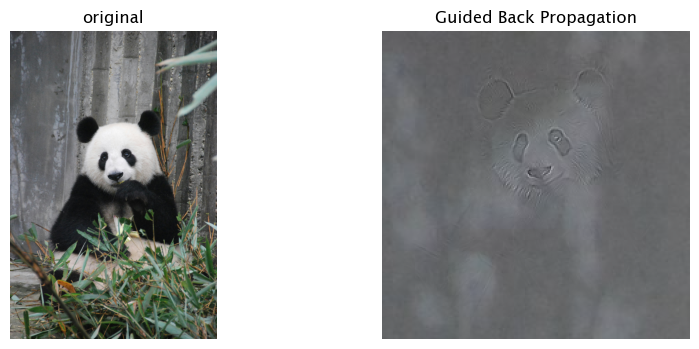

In [21]:
gbp = GuidedBackprop(model)

input_tensor.requires_grad =True

attributions_gbp = gbp.attribute(
    input_tensor ,
    target= target ,
 )

attr_gbp =attributions_gbp.squeeze().detach().cpu().numpy()

attr_gbp =attr_gbp.sum(axis=0)
attr_gbp_norm =(attr_gbp -attr_gbp.min())/(attr_gbp.max()- attr_gbp.min() + 1e-8)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img_pil)
plt.title("original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img_pil)
plt.imshow(attr_gbp,cmap="gray",alpha=0.5)
plt.title("Guided Back Propagation")
plt.axis("off")
plt.show()

In [22]:
pip install numpy==2.0

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 1.4 MB/s  0:00:03m 1.5 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
captum 0.8.0 requires numpy<2.0, but you have numpy 2.0.0 which is incompatible.
tensorflow 2.20.0 requires keras>=3.10.0, but you have keras 2.15.0 which is incompatible.
tensorflow 2.20.0 requires ml_dtypes<1.0.0,>=0.5.1, but you have ml-dtypes 0.2.0 which is incompatible.
tensorflow 2.20.0 requires protobuf>=5.28.0, but you have protobuf 4.25.8 which is incompatible.
tensorflow 2

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets , transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

##LIME for images
from lime import lime_image
from skimage.segmentation import mark_boundaries

import shap

from pytorch_grad_cam import GradCAM , GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

from captum.attr import IntegratedGradients , Occlusion , GuidedBackprop

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [24]:
from torchvision.models import resnet50, ResNet50_Weights

weights =ResNet50_Weights.DEFAULT
model =resnet50(weights=weights)
model = model.eval().to(device)

##pre processing transform for ImageNet models
preprocess =weights.transforms() 
imagenet_labels = weights.meta['categories']

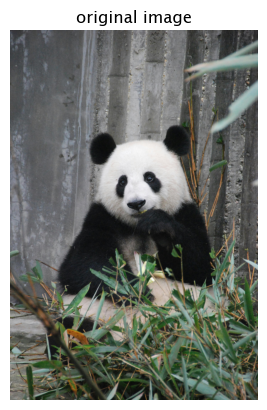

In [42]:
# image_location='pexels-chevanon-1108099.jpg'
image_location='pexels-laurathexplaura-3608263.jpg'

img_pil = Image.open(image_location).convert("RGB")
plt.imshow(img_pil)
plt.axis('off')
plt.title('original image')
plt.show()

In [30]:
def prepare_image(img_pil):
    input_tensor = preprocess(img_pil).unsqueeze(0).to(device)
    return input_tensor ##[c,h,w ] - we want [1,c,h,w]

def predict(input_tensor):
    with torch.no_grad():
        logits = model(input_tensor)
        probs = logits.softmax(dim=1)
    return probs,logits

model.eval()
input_tensor = prepare_image(img_pil)
probs , logits =predict(input_tensor)
top_prob,top_idx =probs.max(dim=1)
pred_label =imagenet_labels[top_idx.item()]
 
print(f'Top prediction :{pred_label} (prob ={top_prob.item():.3f})')

Top prediction :giant panda (prob =0.456)


### Grad -CAM 
Grad-CAM shows which regions in the LAST convolutional layer activated most for your prediction. It's like asking "What did the model's 'deep understanding' focus on?"

1. Forward pass: input → layer4[-1] → final prediction ✓
2. Backward pass: ∂"Golden Retriever score"/∂layer4[-1] → GRADIENTS [1,C,7,7]
3. Global avg pool gradients over H,W → WEIGHTS [1,C,1,1] (C=2048 weights)
4. Weighted sum: Σ(weights_c × activation_c) → CAM [1,1,7,7]
5. ReLU(CAM) → POSITIVE contributions only [7,7]
6. Normalize [0,1] → grayscale_cam


Text(0.5, 1.0, 'Grad-CAM')

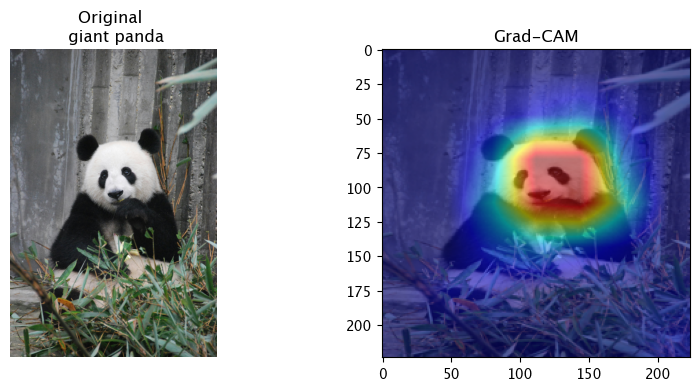

In [33]:
import numpy as np
import matplotlib.pyplot as plt

from pytorch_grad_cam import GradCAM , GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

model.eval()
model.to(device)
input_tensor =input_tensor.to(device)
target = top_idx.item()

## target conv layer -last block of resnet 50
# ResNet50 structure:
# layer1 → layer2 → layer3 → layer4 (deepest!)
#   ↓         ↓        ↓       ↓ (7x7 feature maps)
# Shallow    Mid     Deep   DEEPEST = BEST for Grad-CAM

target_layers =[model.layer4[-1]]

##create grad -cam object
cam = GradCAM(
    model =model ,
    target_layers =target_layers
)

targets= [ ClassifierOutputTarget(target)]
##compute grad-cam mask
grayscale_cam = cam(input_tensor = input_tensor , targets =targets)[0] # [H_cam,W_cam]
##Resize the org image to same size as the mask
H_cam,W_cam =grayscale_cam.shape
img_resized =img_pil.resize((W_cam,H_cam))

rgb_img = np.array(img_resized).astype(np.float32)/ 255.0 #[H_cam , W_cam ,3

#overlay heatmap on resized image
visualization = show_cam_on_image(rgb_img , grayscale_cam , use_rgb=True)

plt.figure(figsize =(10,4))

plt.subplot(1,2,1)
plt.imshow(img_pil)
plt.title(f"Original \n {pred_label}")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(visualization)
plt.title("Grad-CAM")



Text(0.5, 1.0, 'Grad-CAM ++')

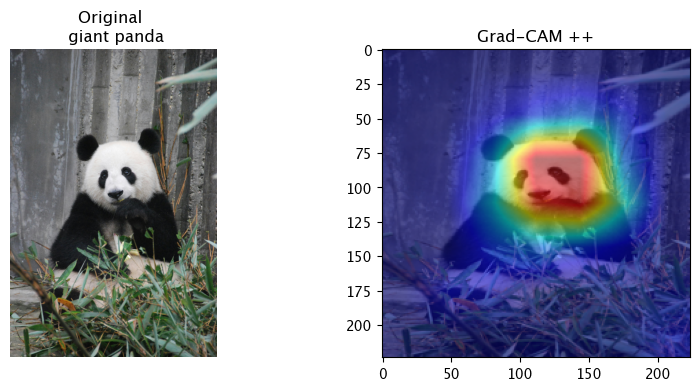

In [39]:
import numpy as np
import matplotlib.pyplot as plt

from pytorch_grad_cam import  GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

model.eval()
model.to(device)
input_tensor =input_tensor.to(device)
target = top_idx.item()

## target conv layer -last block of resnet 50
# ResNet50 structure:
# layer1 → layer2 → layer3 → layer4 (deepest!)
#   ↓         ↓        ↓       ↓ (7x7 feature maps)
# Shallow    Mid     Deep   DEEPEST = BEST for Grad-CAM

target_layers =[model.layer4[-1]]

##create grad -cam object
cam = GradCAMPlusPlus(
    model =model ,
    target_layers =target_layers
)

targets= [ ClassifierOutputTarget(target)]
##compute grad-cam mask
grayscale_cam = cam(input_tensor = input_tensor , targets =targets)[0] # [H_cam,W_cam]
##Resize the org image to same size as the mask
H_cam,W_cam =grayscale_cam.shape
img_resized =img_pil.resize((W_cam,H_cam))

rgb_img = np.array(img_resized).astype(np.float32)/ 255.0 #[H_cam , W_cam ,3

#overlay heatmap on resized image
visualization = show_cam_on_image(rgb_img , grayscale_cam , use_rgb=True)

plt.figure(figsize =(10,4))

plt.subplot(1,2,1)
plt.imshow(img_pil)
plt.title(f"Original \n {pred_label}")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(visualization)
plt.title("Grad-CAM ++")

### LIME

In [41]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [45]:
def batch_predict(images):
    """
    images : list/ array of images as float32 in [0,1] , shape (H,W,3)
    returns : numpy array of probabilities [N , num_classes]
    
    """
    model.eval()
    batch_tensors=[]
    for img in images:
        pil = image.fromarray((img * 255 ).astype(np.uint8))
        t =preprocess(pil)
        batch_tensors.append(t)

    batch =torch.stack(batch_tensors).to(device) #[N,3,224,224]
    with torch.no_grad():
        logits = model(batch)
        probs = logits.softmax(dim=1)
    return probs.cpu().numpy()

img_lime = np.array(img_pil).astype(np.float32) /255.0

explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(
    img_lime,
    batch_predict ,
    top_labels =5 ,
    hide_color = 0,
    num_samples =20
)

lime_label =target

temp,mask = explanation.get_image_and_mask(
    lime_label ,
    positive_only =True ,
    num_features =5 ,
    hide_rest =False
)

plt.figure(figsize =(10,4))

plt.subplot(1,2,1)
plt.imshow(img_pil)
plt.title(f"Original \n {pred_label}")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(mark_boundaries(temp/255.0,mask))
plt.title("LIME - important superpixels")
plt.axis("off")

plt.tight_layout()
plt.show()

        
        
    

  0%|          | 0/20 [00:00<?, ?it/s]

NameError: name 'image' is not defined